In [1]:
using Pkg
Pkg.activate("../")
Pkg.develop(path="../../TAMBO-MC/Tambo/")

  Activating project at `~/research/tambo_point_source`
   Resolving package versions...
  No Changes to `~/research/tambo_point_source/Project.toml`
  No Changes to `~/research/tambo_point_source/Manifest.toml`


In [2]:
using Tambo
using Revise
using GeoMakie
using CairoMakie
# using Proj4
using GeoJSON
using StaticArrays
using Makie.GeometryBasics
includet("../src/conversions.jl")

In [3]:
countries_file = GeoMakie.assetpath("vector", "countries.geo.json")
const countries = GeoJSON.read(read(countries_file, String))

FeatureCollection with 180 Features

In [4]:
function setup_geoax(
    long0,
    ocean_color,
    landcolor
)
    lats = -89.5:1:89.5
    lons = 0.5:1:359.5
    lons = lons .- 180 # this command MUST be done for things to work

    color = [landcolor for _ in 1:length(countries)]
    
    hm = poly!(ax, countries; color=color,
        strokecolor = :black, strokewidth = 0.25,
        shading=NoShading,
    )
    
    field = [1 for _ in lons, _ in lats]
    surface!(ax, lons, lats, field; colormap=[ocean_color, ocean_color])
    
    source = Projection("+proj=lonlat")
    dest = Projection("+proj=moll +lon_0=$lon0")
    xs, ys = xygrid(lons, lats)
    Proj4.transform!(source, dest, vec(xs), vec(ys))
    scene = surface(xs, ys, zeros(size(xs)); color = field, shading = false, show_axis = false)

    geoaxis!(scene, long0-180, long0+180, -90, 90; crs = (src = source, dest = dest,))
    coastlines!(scene, 1; crs = (src = source, dest = dest,))
    
    return scene
end

setup_geoax (generic function with 1 method)

In [5]:
AstroLib.observatories["icecube"] = AstroLib.Observatory(
    "IceCube",
    -90 * units.degree,
    0 * units.degree,
    -1947 * units.m,
    0.0
)

AstroLib.observatories["pone"] = AstroLib.Observatory(
    "P-ONE",
    48.4284 * units.degree,
    -123.3656 * units.degree,
    -1947 * units.m,
    -8
)

AstroLib.observatories["arca"] = AstroLib.Observatory(
    "KM3NeT-ARCA",
    ten(36, 16) * units.degree,
    ten(16, 6) * units.degree,
    -1947 * units.m,
    1
)

AstroLib.observatories["gvd"] = AstroLib.Observatory(
    "Baikal-GVD",
    53.5587*units.degree,
    108.1650*units.degree, 
    -800units.m,
    -7
)

AstroLib.observatories["tambo"] = AstroLib.Observatory(
    "TAMBO",
    whitepaper_coord.latitude,
    whitepaper_coord.longitude,
    2units.m,
    -7
)

Observatory: TAMBO
latitude:    -0.2729455840011608°N
longitude:   -1.2595165056358575°E
altitude:    1.013546187482e7 m
time zone:   UTC-7

In [6]:
function altaz2localhadec(obs, θ, ϕ)
    ha, δ = altaz2hadec(θ, ϕ, rad2deg(obs.latitude))
    ha += rad2deg(obs.longitude)
    # Make sure it is in range 0 <= ha < 360
    ha = mod(ha + 360, 360)
    # Move hour angle to -180 < ha <= 180
    ha = 180 < ha ? ha - 360 : ha
    return ha, δ
end

altaz2localhadec (generic function with 1 method)

In [7]:
function lerp(p1, p2, λ)
    @assert 0 <= λ <= 1
    return ((p2 .- p1) .* λ) .+ p1
end

lerp (generic function with 1 method)

In [8]:
function make_outline(
    obs::AstroLib.Observatory,
    θs::Tuple{Real, Real},
    ϕs::Tuple{Real, Real},
)
    # Make sure phis are ordered
    if ϕs[1] > ϕs[2]
        ϕs = (ϕs[2], ϕs[1])
    end

    pss = []
    
    for (idx, θ) in enumerate(θs)  
        ps = Tuple{Float64, Float64}[]
        
        ha0, _ = altaz2localhadec(obs, θ, ϕs[1])
        
        switch_idx = nothing
        did_switch = false
        
        for (jdx, az) in enumerate(LinRange(ϕs[1], ϕs[2], 300))
            ha, δ = altaz2localhadec(obs, θ, az)
            if ha < sign(obs.latitude) * ha0 && ~did_switch
                did_switch = true
            end
            
            push!(ps, (ha, δ))
        end
        
        # if did_switch
        #     ps = vcat(
        #         ps[switch_idx:end],
        #         ps[1:switch_idx-1]
        #     )
        # end
        if did_switch
            sort!(ps)
        end
        push!(pss, ps)
        
    end
    
    ugh = vcat(
        pss[1],
        lerp.(Ref(pss[1][end]), Ref(pss[2][end]), LinRange(0.01, 0.99, 20)),
        reverse(pss[2]),
        lerp.(Ref(pss[2][1]), Ref(pss[1][1]), LinRange(0, 1, 20)),
        [pss[1][1]]
    )
    
    return ugh
end

make_outline (generic function with 1 method)

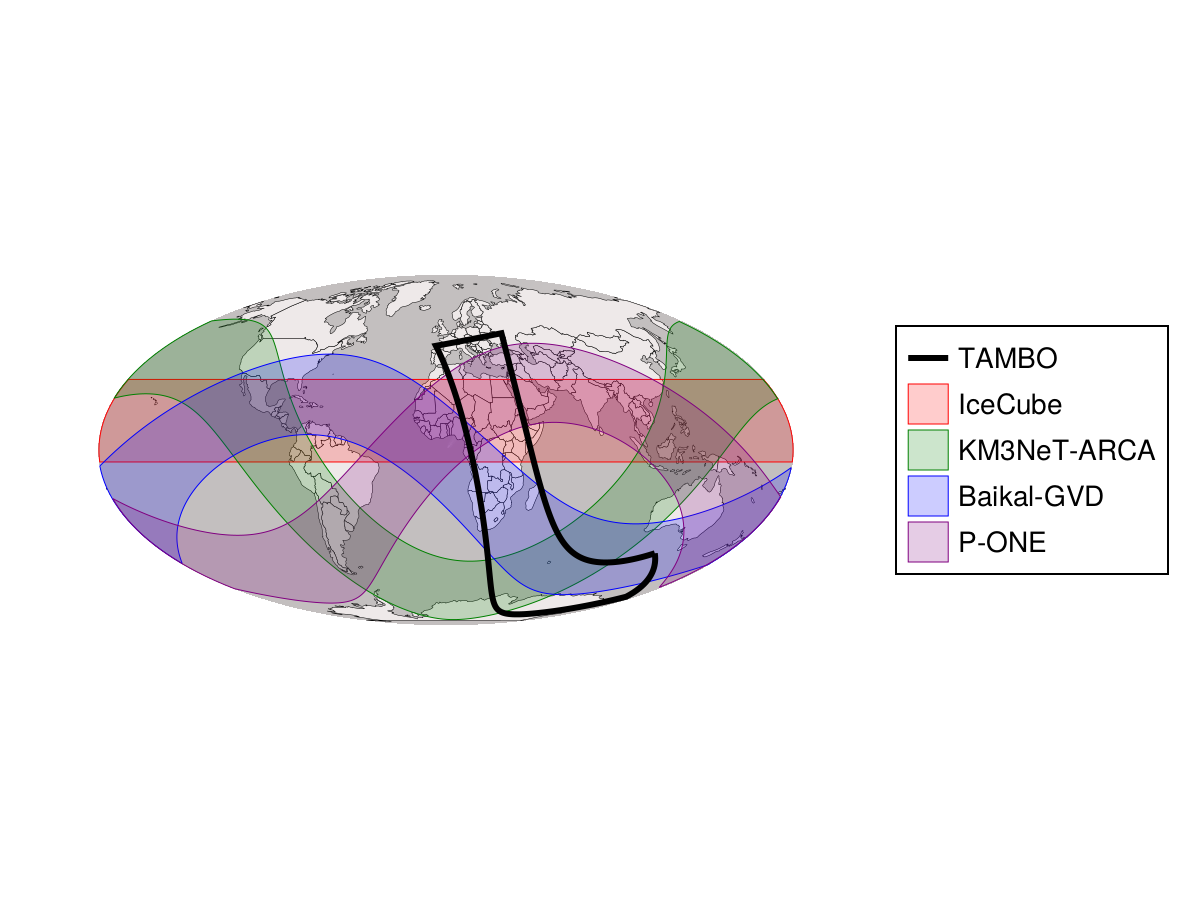

CairoMakie.Screen{IMAGE}


In [23]:
fig = Figure()
ax = GeoAxis(
    fig[1,1],
    xticklabelsvisible = false,
    yticklabelsvisible = false,
    xgridvisible=false,
    ygridvisible=false,
    dest="+proj=moll"
)

lats = -89.5:1:89.5
lons = 0.5:1:359.5
lons = lons .- 180 # this command MUST be done for things to work


field = [1 for _ in lons, _ in lats]
surface!(ax, lons, lats, field; colormap=[:snow, :snow])
cs = [:snow2 for _ in 1:length(countries)]
hm = poly!(ax, countries; color=cs,
    strokecolor = :black, strokewidth = 0.25,
    shading=NoShading,
)

observatories = [
    AstroLib.observatories["icecube"],
    AstroLib.observatories["arca"],
    AstroLib.observatories["gvd"],
    AstroLib.observatories["pone"],
]

cs = [:red, :green, :blue, :purple]

legend_elements = []

for (c, observatory) in zip(cs, observatories)

    ps = make_outline(observatory, (-30, 5), (0, 360))

    p = poly!(
        ax,
        Polygon(Point2f.(ps)),
        alpha=0.1,
        color=(c, 0.2),
        strokecolor=c,
        strokewidth=0.5
    )
    
    push!(legend_elements, (p, observatory.name))
    
end

ps = make_outline(AstroLib.observatories["tambo"], (-25, 5), (-40, -200))

l = lines!(
    ax,
    [p[1] for p in ps],
    [p[2] for p in ps],
    linewidth=3,
    color=:black
)

Legend(fig[1, 2],
    vcat(l, [le[1] for le in legend_elements]),
    vcat("TAMBO", [le[2] for le in legend_elements]),
)

display(fig)

In [438]:
Line(
    StaticArraysCore.SVector{2, GeometryBasics.Point{2, Float32}}([1f0,2f0]),
    StaticArraysCore.SVector{2, GeometryBasics.Point{2, Float32}}([3f0,4f0])
)

LoadError: MethodError: [0mCannot `convert` an object of type [92mFloat32[39m[0m to an object of type [91mGeometryBasics.Point{2, Float32}[39m

[0mClosest candidates are:
[0m  convert(::Type{GeometryBasics.Point{S, T}}, [91m::Tuple{Vararg{T, S}}[39m) where {S, T}
[0m[90m   @[39m [32mGeometryBasics[39m [90m~/.julia/packages/GeometryBasics/bLARu/src/[39m[90m[4mfixed_arrays.jl:94[24m[39m
[0m  convert(::Type{GeometryBasics.Point{S, T}}, [91m::Tuple[39m) where {S, T}
[0m[90m   @[39m [32mGeometryBasics[39m [90m~/.julia/packages/GeometryBasics/bLARu/src/[39m[90m[4mfixed_arrays.jl:97[24m[39m
[0m  convert(::Type{GeometryBasics.Point{S, T}}, [91m::GeometryBasics.Point[39m) where {S, T}
[0m[90m   @[39m [32mGeometryBasics[39m [90m~/.julia/packages/GeometryBasics/bLARu/src/[39m[90m[4mfixed_arrays.jl:67[24m[39m
[0m  ...


In [430]:
a = GeoMakie.coastlines()[1][1]

Line(Float32[-163.71289, -78.595665] => Float32[-163.1058, -78.223335])

In [452]:
Line(
    GeometryBasics.Point{2, Float32}( -163.71289,  -163.71289),
    GeometryBasics.Point{2, Float32}( -163.,  -163.71289)
)

Line(Float32[-163.71289, -163.71289] => Float32[-163.0, -163.71289])

In [431]:
function rotate_coastlines(coastlines, ϕ)

2-element StaticArraysCore.SVector{2, GeometryBasics.Point{2, Float32}} with indices SOneTo(2):
 [-163.71289, -78.595665]
 [-163.1058, -78.223335]

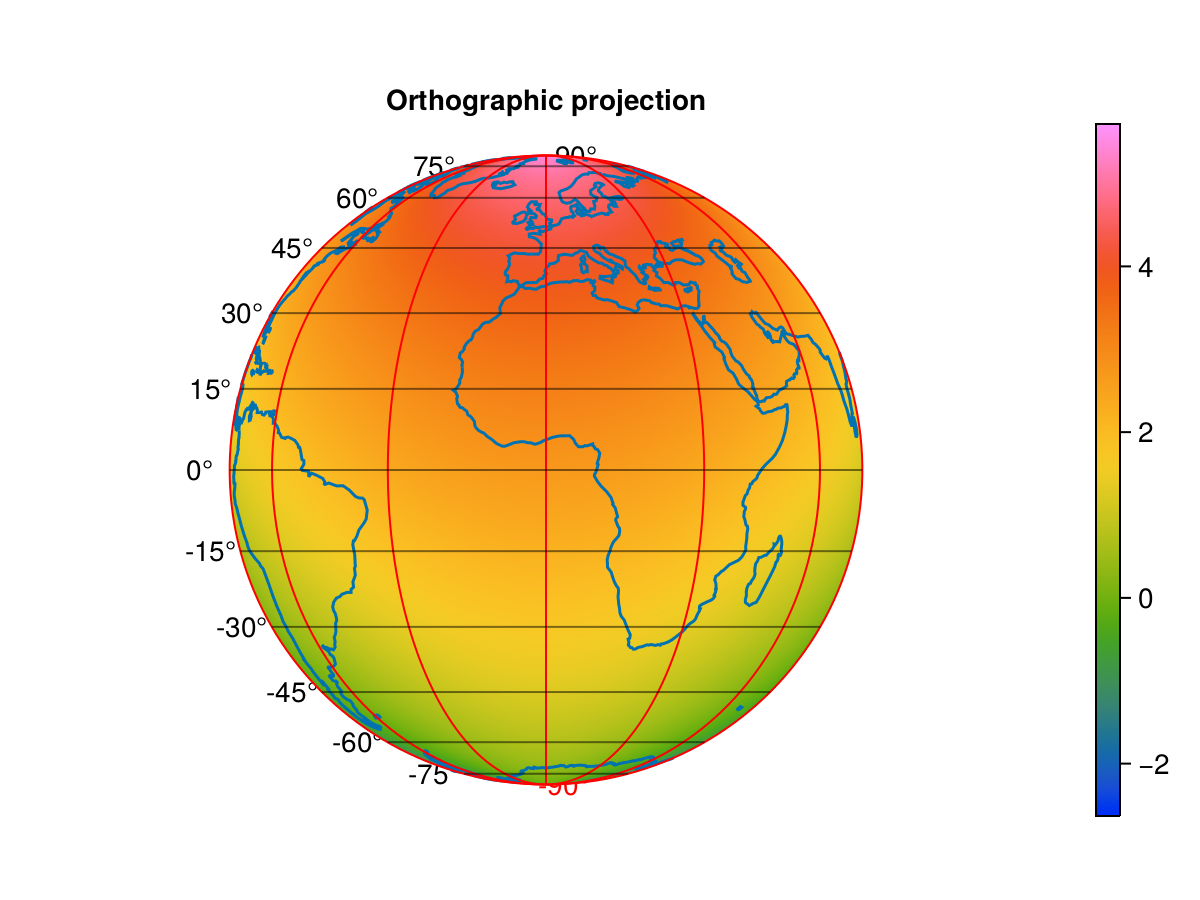

In [422]:
using GeoMakie, CairoMakie

lons = -180:180
lats = -90:90
field = [exp(cosd(l)) + 3(y/90) for l in lons, y in lats]

fig = Figure()
ga = GeoAxis(
    fig[1, 1],
    dest="+proj=ortho",
    title = "Orthographic projection",
    xticklabelcolor=:red, xgridcolor=:red,
)
lp = lines!(ga, GeoMakie.coastlines(); transformation = (; translation = (0, 0, 1)))
sp = surface!(ga, lons, lats, zeros(size(field)); color=field, shading = NoShading, colormap=:rainbow_bgyrm_35_85_c69_n256)
cb = Colorbar(fig[1, 2], sp)
fig



In [423]:
methods(GeoMakie.coastlines)

# 1 method for generic function "coastlines" from GeoMakie:
 [1] coastlines()
     @ ~/.julia/packages/GeoMakie/vcMuZ/src/data.jl:11

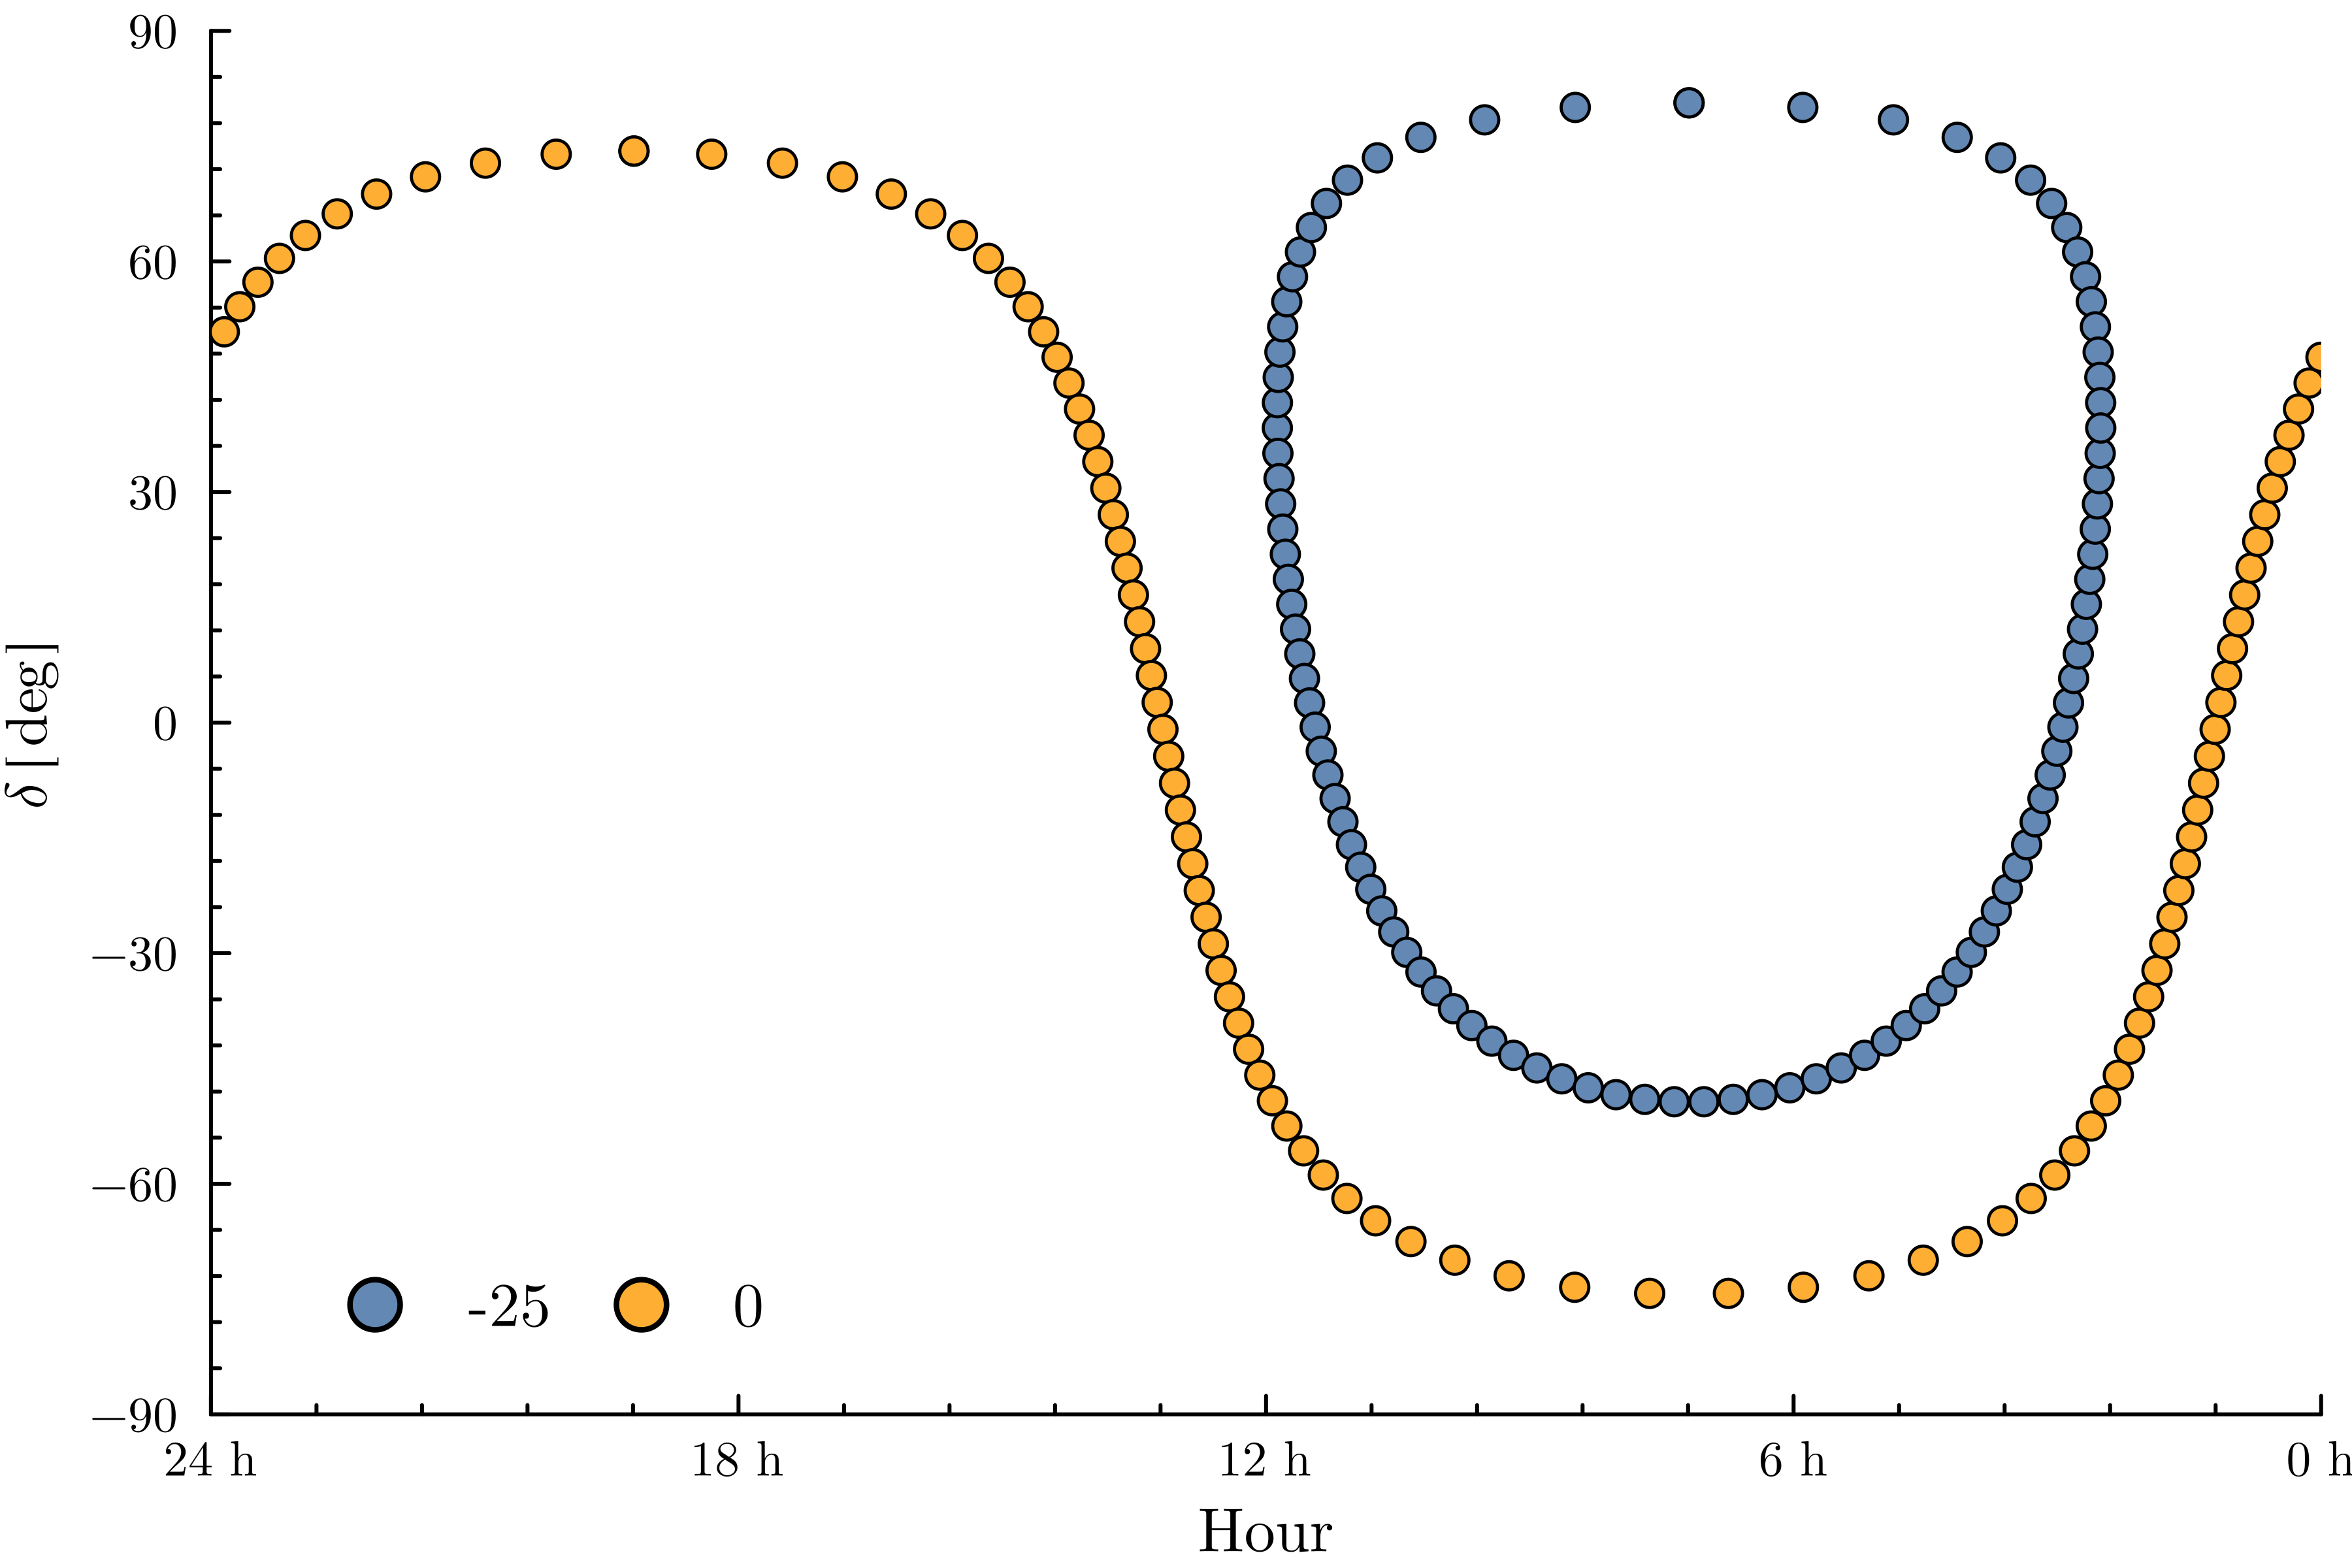

In [6]:
plt = plot(
    size=(600, 400),
    xlims=(0, 360),
    ylims=[-90, 90],
    xticks=([0, 90, 180, 270, 360], ["24 h", "18 h", "12 h", "6 h", "0 h"]),
    xlabel="Hour",
    ylabel=L"δ~\left[\mathrm{deg}\right]",
    legend_column=2
)

# colors = [:red, :green, :blue]
# lats = [49.1973848, ten(36, 16), -90]
# longs = [-123.3, ten(16, 06), 0]


# for (color, lat, long) in zip(colors, lats, longs)

#     for θ in deg2rad.([-30, 5])
#         has = []
#         δs = []
#         for az in 0:0.1:2π
#             ha, δ = altaz2hadec(rad2deg(θ), rad2deg(az), lat)
#             ha += long + 360
#             ha = ha % 360
#             push!(has, ha)
#             push!(δs, δ) 
#         end
#         xs = 360 .- has
#         sorter = sortperm(xs)
#         plot!(plt, xs[sorter], δs[sorter], label="", color=color)
#     end
# end

lat = rad2deg(whitepaper_coord.latitude)
long = rad2deg(whitepaper_coord.longitude)

for θ in [-25, 0]
    has = []
    δs = []
    for az in LinRange(0, 360, 100)
        ha, δ = altaz2hadec(θ, az, lat)
        ha += long + 360
        ha = ha % 360
        push!(has, ha)
        push!(δs, δ) 
    end
    xs = 360 .- has
    sorter = sortperm(xs)
    scatter!(plt, xs[sorter], δs[sorter], lw=3, label=θ)
end

display(plt)

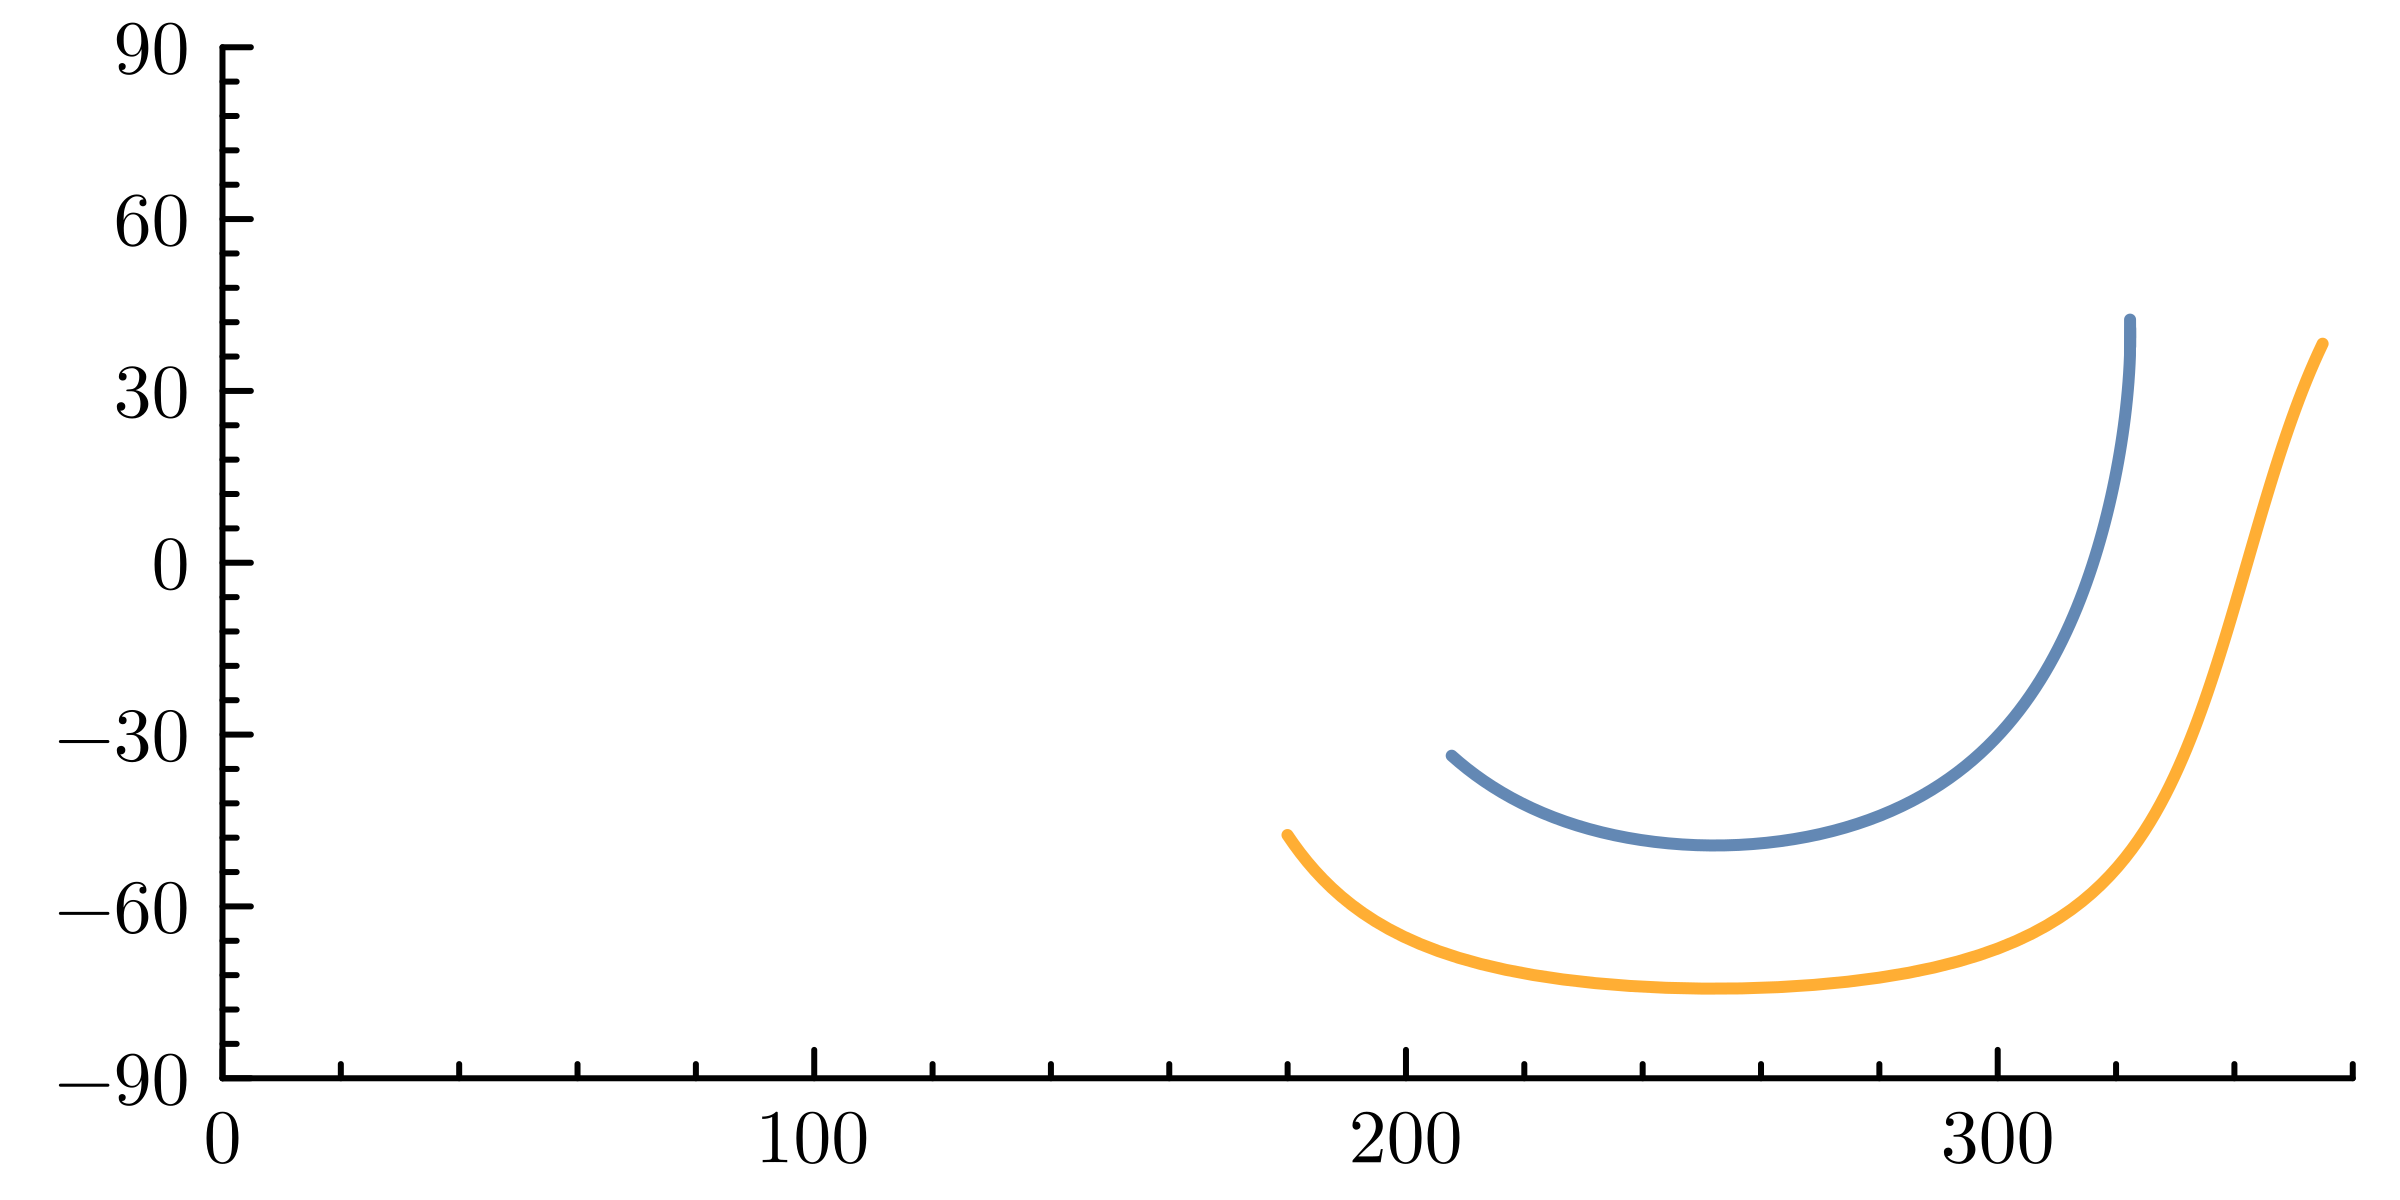

In [8]:
plt = plot(
    xlims=(0, 360),
    ylims=[-90, 90]
)

lat = rad2deg(whitepaper_coord.latitude)
long = rad2deg(whitepaper_coord.longitude)

for θ in [-25, 0]
    has = []
    δs = []
    for az in LinRange(-50, -220, 100)
        ha, δ = altaz2hadec(θ, az, lat)
        ha += long + 360
        ha = ha % 360
        push!(has, ha)
        push!(δs, δ) 
    end
    xs = 360 .- has
    sorter = sortperm(xs)
    plot!(plt, xs[sorter], δs[sorter], label="")
end
display(plt)

In [9]:
using Tables
using Healpix

In [10]:
# abstract type AbstractSkyMap end
# struct SkyMapHealpix{HMT} <: AbstractSkyMap
#     hpix::HMT
# end

# ix_to_coords(m::SkyMapHealpix, ix::Int) = let
#     codec, ra = Healpix.pix2ang(m.hpix, ix)
#     return SVector(ra, Healpix.colat2lat(codec))
# end
# find_closest(m::SkyMapHealpix, (ra, dec)) = Healpix.ang2pix(m.hpix, Healpix.lat2colat(dec), ra)	
# (m::SkyMapHealpix)(radec) = m.hpix[find_closest(m, radec)]

# Tables.istable(m::SkyMapHealpix) = true	
# Tables.rowaccess(m::SkyMapHealpix) = true
# Tables.rows(m::SkyMapHealpix) = map(ix -> (coords=ix_to_coords(m, ix), value=m.hpix[ix]), 1:length(m.hpix))

In [11]:
mymap = Healpix.HealpixMap{Int64, Healpix.RingOrder}(1:Healpix.nside2npix(64))

49152-element HealpixMap{Int64, RingOrder, Vector{Int64}}:
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
    11
    12
    13
     ⋮
 49141
 49142
 49143
 49144
 49145
 49146
 49147
 49148
 49149
 49150
 49151
 49152

In [12]:
observatory = AstroLib.observatories["pone"]

for θ in [-30, 5]
    has = []
    δs = []
    for az in 0:0.1:2π
        ha, δ = altaz2hadec(θ, rad2deg(az), observatory.latitude / units.degree)
        ha += observatory.longitude / units.degree + 360
        ha = ha % 360
        push!(has, ha)
        push!(δs, δ)
        
    end
end

In [15]:
Healpix.ang2pix(mymap, π/2, 4)

24611

In [16]:
for px in mymap.pixels
    mymap[px] = 0  
end

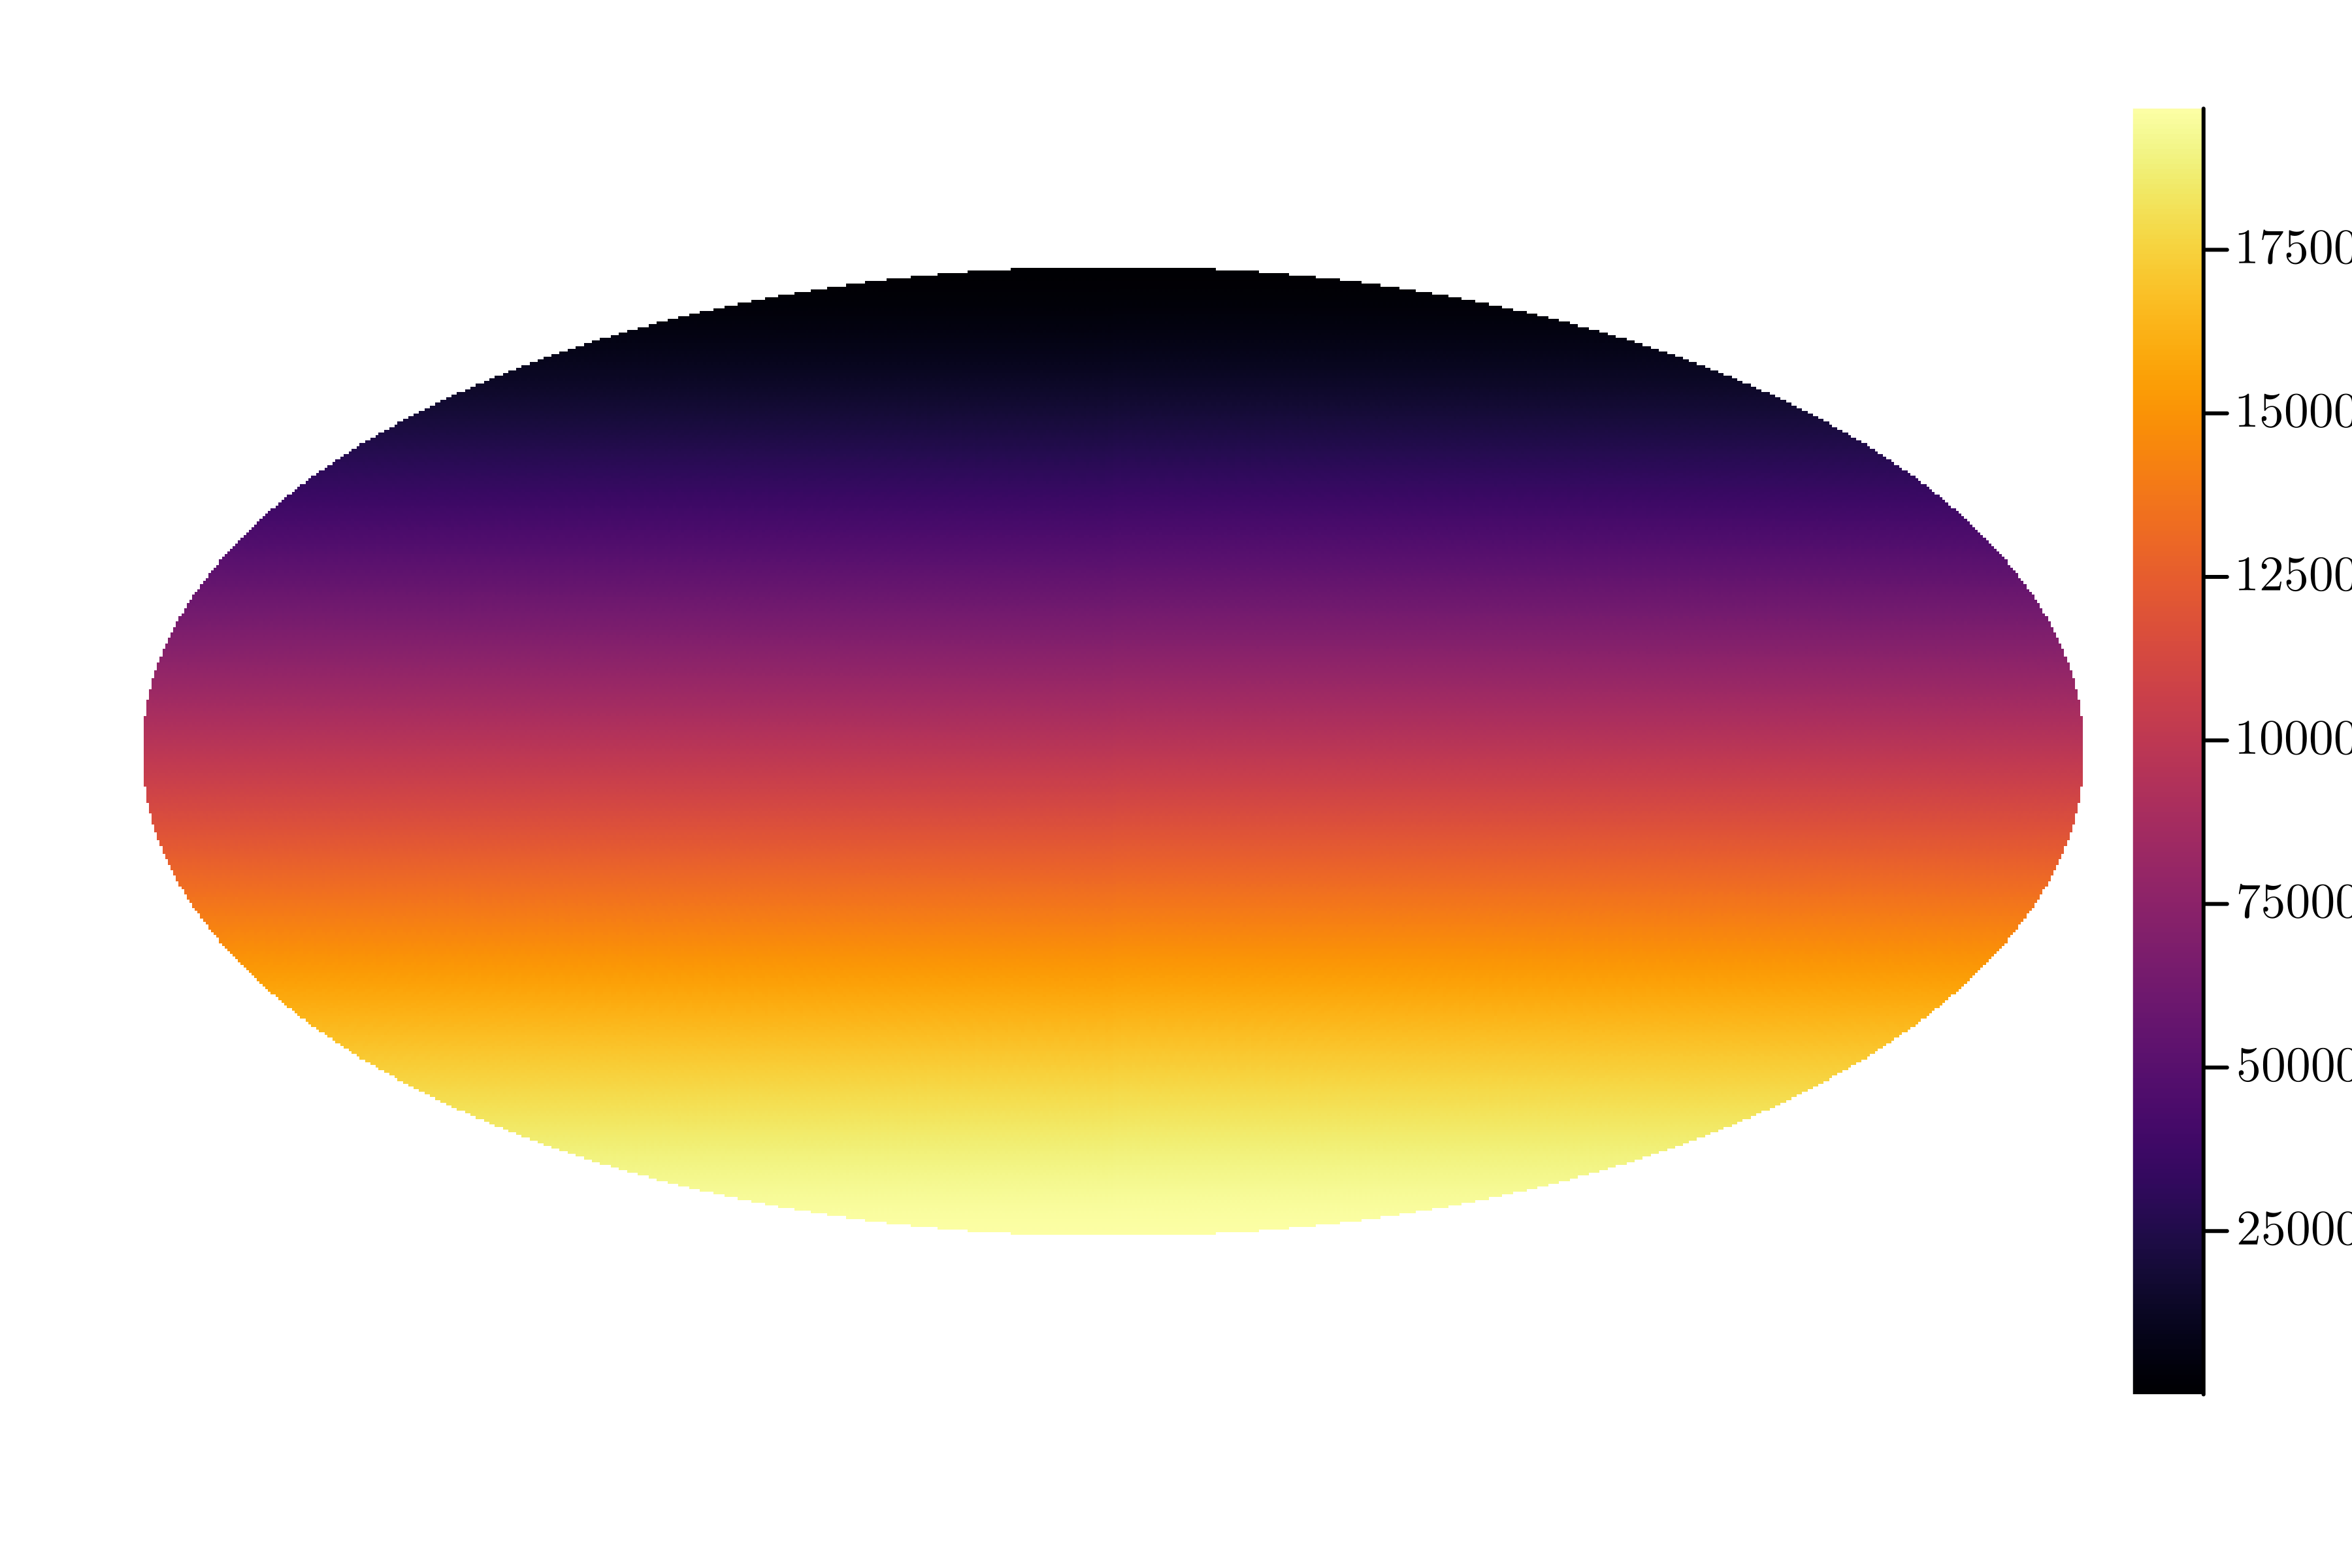

In [27]:
mymap = Healpix.HealpixMap{Int64, Healpix.RingOrder}(1:Healpix.nside2npix(128))
# for px in mymap.pixels
#     mymap[px] = 0  
# end

plt = plot(size=(600,400))
plot!(plt, mymap)
observatories = AstroLib.Observatory[
    AstroLib.observatories["icecube"],
    AstroLib.observatories["gvd"],
    AstroLib.observatories["arca"],
    AstroLib.observatories["pone"],
]

has = nothing
δs = nothing

for (idx, observatory) in enumerate(observatories)
    for θ in [-30, 5]
        has = []
        δs = []
        for az in 0:0.001:2π
            ha, δ = altaz2hadec(θ, rad2deg(az), observatory.latitude / units.degree)
            ha += observatory.longitude / units.degree + 360
            ha = ha % 360
            push!(has, ha)
            push!(δs, δ)

            # px = Healpix.ang2pix(mymap, π / 2 - deg2rad(δ), deg2rad(ha))
            # mymap[px] = idx
        end
        # plot!(plt, )
    end
end

display(plt)

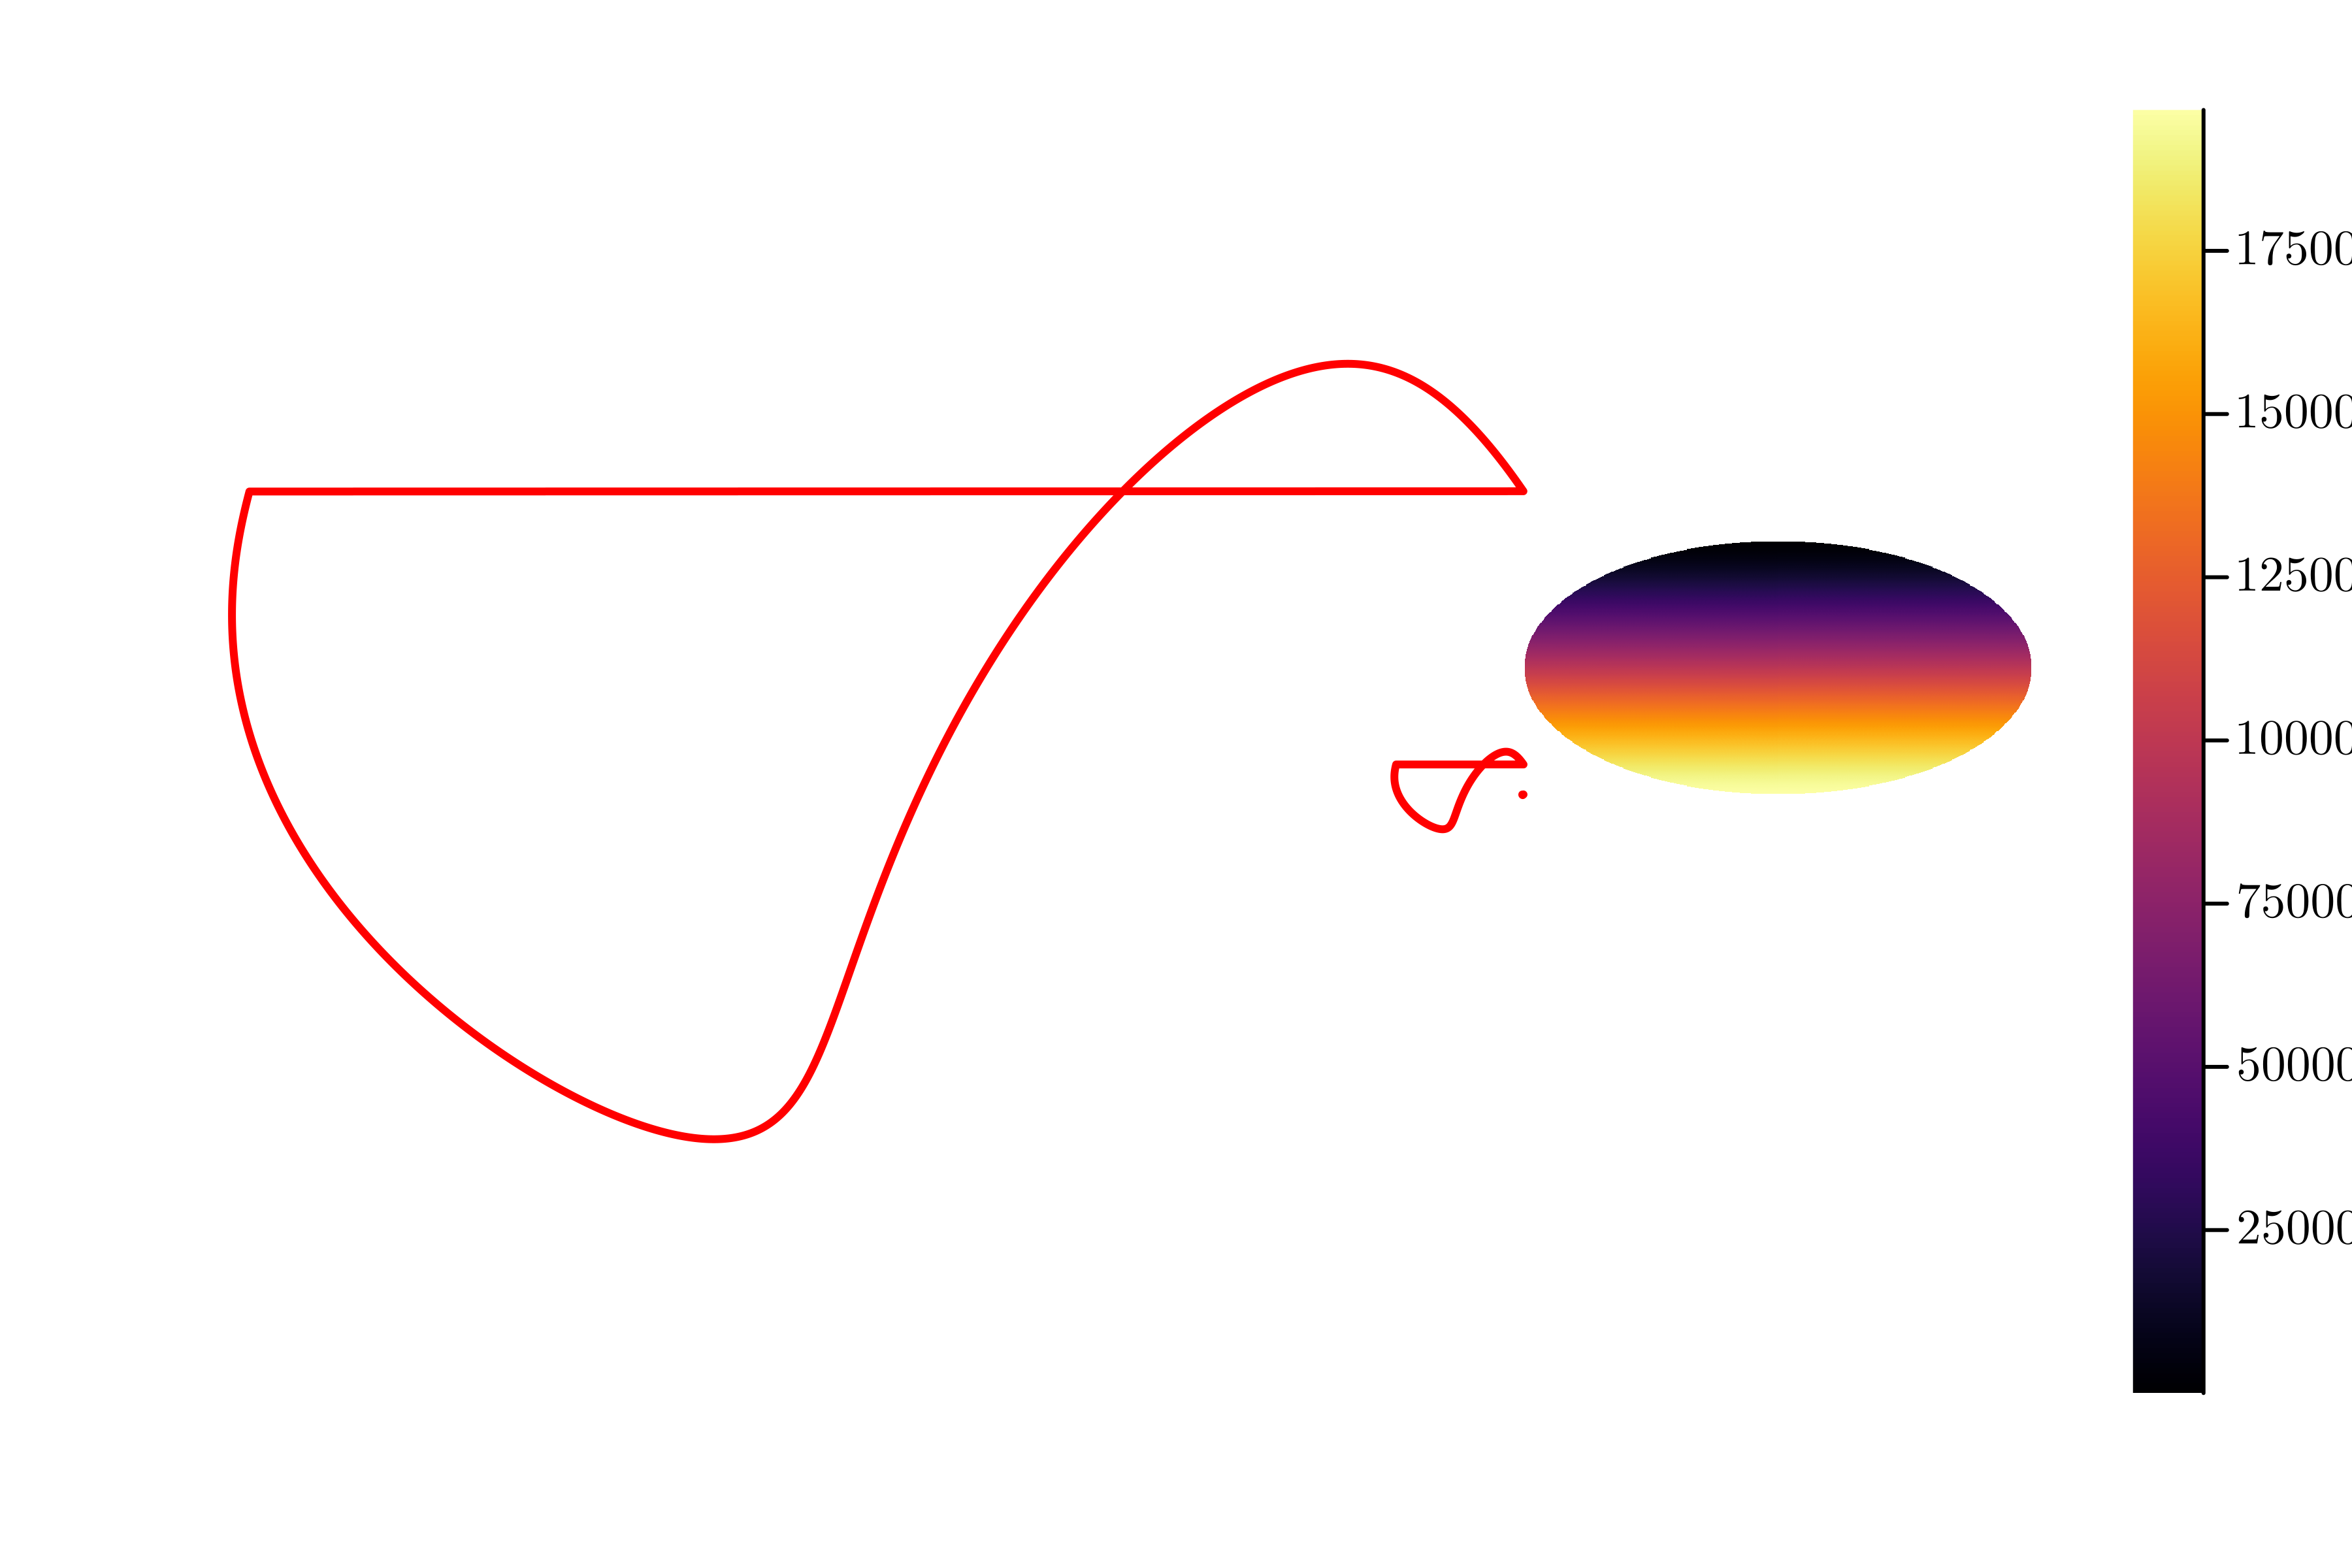

In [30]:
a = mollweideproj.(deg2rad.(δs), deg2rad.(has))
plot!(plt, [1000 * x[2] for x in a], 1000 * [x[3] for x in a], color="red")